# Preparation
<a id=preparation />

In [ ]:
%run "../Functions/6. Time analysis.ipynb"
%run "../Functions/Plot.ipynb"

# April 2018 Playtest

In [ ]:
rmdf1522.columns

In [ ]:
#testUserId1 = 'f4589007-0809-4673-ad50-d985abe4fa65'
#testUserId2 = '653f174e-c23f-4d3a-94f6-d26b53ac7168'
#gform[gform[QUserId] == testUserId2]
#testUserId2 in testUsers

## labels

In [ ]:
# rows
phase1Label = 'phase1'
phase2Label = 'phase2'
totalLabel = 'total'

# columns
playersCountLabel = 'players'
respondersCountLabel = 'responders'
respondersTwiceCountLabel = 'twice responders'
prefixFemale = 'f '
prefixMale = 'm '


playtestStatistics = pd.DataFrame(
    data = np.nan,
    index = [phase1Label, phase2Label, totalLabel],
    columns = [playersCountLabel]
)

## functions

In [ ]:
# problem: counts UserIds, but there can be more than one subject per UserId
def setCount(rmdf, rowLabel, columnLabel):
    playtestStatistics.loc[rowLabel, columnLabel] = len(rmdf[QUserId].unique())
    return playtestStatistics.loc[rowLabel, columnLabel]

def setGenderedCount(rmdf, sampledGform, rowLabel, columnLabel, plotPie = False, title = ''):
    femaleResponders = sampledGform[sampledGform[QGender] == "Female"][QUserId]
    maleResponders = sampledGform[sampledGform[QGender] == "Male"][QUserId]

    femaleSample = rmdf[rmdf[QUserId].isin(femaleResponders)]
    maleSample = rmdf[rmdf[QUserId].isin(maleResponders)]

    tCount = setCount(rmdf, rowLabel, columnLabel)
    fCount = setCount(femaleSample, rowLabel, prefixFemale + columnLabel)
    mCount = setCount(maleSample, rowLabel, prefixMale + columnLabel)
    oCount = tCount-fCount-mCount
    
    if plotPie:
        plt.pie([fCount, mCount, oCount], labels=['Female', 'Male', 'Other/Unknown'], autopct='%1.1f%%', shadow=True)
        plt.title(title)
        plt.show()

In [ ]:
def getUniqueProfiles(sampleForm):
    playtestProfiles = sampleForm.loc[:,[QUserId, QAge, QGender]]
    playtestProfiles.drop_duplicates(subset=[QUserId, QAge, QGender], keep='first', inplace=True)
    return playtestProfiles

In [ ]:
def getTicksByStep(minValue, maxValue, step):
    start = minValue + step - (minValue % step)
    end = maxValue - (maxValue % step) + step

    ticks = [x for x in range(start, end, step)]
    ticks = np.append([minValue], ticks)
    ticks = np.append(ticks, [maxValue])

    return ticks

In [ ]:
def getTicks(minValue, maxValue, step = 0, labelCount = 0):
    if step == 0 and labelCount != 0:
        step = int((maxValue - minValue + 1) / labelCount)
    return getTicksByStep(minValue, maxValue, step)

In [ ]:
def plotAge(sampleForm, title = 'Âge des participants', xlabel = 'Âge', ylabel = 'Nombre'):
    playtestProfiles = getUniqueProfiles(sampleForm)

    ages = playtestProfiles[QAge].value_counts().sort_index()
    minAge = ages.index.min()
    maxAge = ages.index.max()
    ages = pd.Series(ages, index=range(minAge, maxAge+1)).fillna(0)
    
    yticks = getTicks(int(ages.min()), int(ages.max()), labelCount = 5)
    ax = ages.plot(kind='bar', yticks=yticks)
    
    #ax = ages.plot(kind='bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # xticks like yticks doesn't work
    # workaround
    xticks = getTicks(minAge, maxAge, step = 5)
    newTicks = xticks - minAge
    newLabels = xticks
    ax.xaxis.set_ticks(newTicks)
    ax.xaxis.set_ticklabels(newLabels)
    
    plt.title(title)
    plt.show()

In [ ]:
#sampleForm = samplePlaytest.copy()
#pivotalAgesList = [3,15,25,35,45,55]
#title = 'Âge des participants'

def plotAgeGroups(sampleForm, pivotalAgesList = [], title = 'Âge des participants', showCount = True):
    playtestProfiles = getUniqueProfiles(sampleForm)

    ages = playtestProfiles[QAge]
    maxAge = ages.max()
    minAge = ages.min()

    pivotalAgesList.sort()
    pivotalAgesList = [x for x in pivotalAgesList if (x < maxAge and x > minAge)]
    pivotalAgesList = np.append(pivotalAgesList, [maxAge])

    ageBins = pd.Series(0,index=pivotalAgesList)
    labels = pd.Series('+++',index=pivotalAgesList)
    previous = str(minAge)

    for pivot in pivotalAgesList:
            ageBins[pivot] = len(ages[ages <= pivot])
            labels[pivot] = previous + '-' + str(pivot)
            if showCount:
                labels[pivot] += " (" + str(ageBins[pivot]) + ")"
            ages = ages[ages >= pivot]
            previous = str(pivot)

    plt.pie(ageBins.values, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.title(title)
    plt.show()

In [ ]:
def plotGender(sampleForm, title = '', labels = ['Femmes', 'Hommes', 'Autres/Non précisé']):
    playtestProfiles = getUniqueProfiles(sampleForm)

    fCount = len(playtestProfiles[playtestProfiles[QGender] == 'Female'])
    mCount = len(playtestProfiles[playtestProfiles[QGender] == 'Male'])
    tCount = len(playtestProfiles)
    oCount = tCount-fCount-mCount

    plt.pie([fCount, mCount, oCount], labels=labels, autopct='%1.1f%%', shadow=True)
    plt.title(title)
    plt.show()
    print("t="+str(tCount))
    print("f="+str(fCount))
    print("m="+str(mCount))
    print("o="+str(oCount))

In [ ]:
def getDuplicates(sample, columns):
    sampled = sample.loc[:,columns]
    return sampled,sampled[sampled.duplicated()]

In [ ]:
#sample = samplePlaytest.copy()
#columns = [QUserId, QAge, QGender, QTemporality]
def getTimedAssembledDuplicates(sample, columns, displayColumns = []):
    if len(displayColumns) == 0:
        displayColumns = columns
        
    sampled,duplicates = getDuplicates(sample, columns)
    dupIndex = pd.Index([])
    for dup in duplicates.values:
        dupbool = [(x == dup).all() for x in sampled.values]
        dupIndex = dupIndex.union(sampled.index[dupbool])
    result = sample.loc[dupIndex, displayColumns].sort_values(by = displayColumns)
    return result

## Dates

In [ ]:
playtest2018Phase1Days = [
    pd.Timestamp('2018-04-10', tz='utc'),	# Tuesday
    pd.Timestamp('2018-04-11', tz='utc'),	# Wednesday

    pd.Timestamp('2018-04-13', tz='utc'),	# Friday
    pd.Timestamp('2018-04-14', tz='utc'),	# Saturday


    pd.Timestamp('2018-04-17', tz='utc'),	# Tuesday
    pd.Timestamp('2018-04-18', tz='utc'),	# Wednesday

    pd.Timestamp('2018-04-20', tz='utc'),	# Friday
    pd.Timestamp('2018-04-21', tz='utc'),	# Saturday


    pd.Timestamp('2018-04-24', tz='utc'),	# Tuesday
    pd.Timestamp('2018-04-25', tz='utc'),	# Wednesday
]

playtest2018Phase2Days = [
    pd.Timestamp('2018-04-27', tz='utc'),	# Friday
    pd.Timestamp('2018-04-28', tz='utc'),	# Saturday
]

playtest2018Days = np.append(playtest2018Phase1Days, playtest2018Phase2Days).tolist()

In [ ]:
playtest2018EuBerTimeStart = pd.Timestamp('11:00:00', tz='Europe/Berlin')
playtest2018EuBerTimeEnd = pd.Timestamp('19:00:00', tz='Europe/Berlin')

playtest2018UTCTimeStart = playtest2018EuBerTimeStart.tz_convert('utc')
playtest2018UTCTimeEnd = playtest2018EuBerTimeEnd.tz_convert('utc')

playtest2018EuBerTimeStartTime = playtest2018EuBerTimeStart.time()
playtest2018EuBerTimeEndTime = playtest2018EuBerTimeEnd.time()

playtest2018EuBerTimeStart, playtest2018EuBerTimeEnd,\
playtest2018UTCTimeStart, playtest2018UTCTimeEnd,\
playtest2018EuBerTimeStartTime, playtest2018EuBerTimeEndTime

### aliases for experiment boundaries

In [ ]:
playtest2018Phase1StartDate = pd.Timestamp.combine(min(playtest2018Phase1Days).date(), playtest2018EuBerTimeStart.tz_convert('Europe/Berlin').time()).tz_localize('Europe/Berlin')
playtest2018Phase1EndDate   = pd.Timestamp.combine(max(playtest2018Phase1Days).date(), playtest2018EuBerTimeEnd.tz_convert('Europe/Berlin').time()).tz_localize('Europe/Berlin')
playtest2018Phase2StartDate = pd.Timestamp.combine(min(playtest2018Phase2Days).date(), playtest2018EuBerTimeStart.tz_convert('Europe/Berlin').time()).tz_localize('Europe/Berlin')
playtest2018Phase2EndDate = pd.Timestamp.combine(max(playtest2018Phase2Days).date(), playtest2018EuBerTimeEnd.tz_convert('Europe/Berlin').time()).tz_localize('Europe/Berlin')
playtest2018Phase1StartDate,playtest2018Phase1EndDate,playtest2018Phase2StartDate,playtest2018Phase2EndDate

In [ ]:
# warning: timestamp = pd.Timestamp('2018-04-24 11:00:11.381000+0000', tz='Europe/Berlin')
#  actually yields Timestamp('2018-04-24 13:00:11.381000+0200', tz='Europe/Berlin') because
#  '+....' codes for timezone, eg here '+0000' codes for UTC timezone

def isPlaytest(timestamp):
    euBerTimestamp = timestamp.tz_convert('Europe/Berlin')
    euBerTimestampTime = euBerTimestamp.time()
    result = (timestamp.tz_convert('utc').floor('d') in playtest2018Days)\
    and (euBerTimestampTime >= playtest2018EuBerTimeStartTime)\
    and (playtest2018EuBerTimeEndTime >= euBerTimestampTime)
    return result

#### isPlaytest day and hour test

In [ ]:
assert(~any([isPlaytest(x) for x in playtest2018Phase1Days]))

In [ ]:
testCorrectTimes = [
                pd.Timestamp('11:00:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('12:43:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('14:58:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('16:38:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('19:00:00', tz='Europe/Berlin').tz_convert('utc'),
]
testIncorrectTimes = [
                pd.Timestamp('19:01:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('21:43:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('23:13:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('06:41:00', tz='Europe/Berlin').tz_convert('utc'),
                pd.Timestamp('10:59:00', tz='Europe/Berlin').tz_convert('utc'),
]

for time in testCorrectTimes:
    correctPlaytestTimes = [pd.Timestamp.combine(x.date(), time.time()).tz_localize('utc') for x in playtest2018Phase1Days]
    assert(all([isPlaytest(x) for x in correctPlaytestTimes]))
    
for time in testIncorrectTimes:
    correctPlaytestTimes = [pd.Timestamp.combine(x.date(), time.time()).tz_localize('utc') for x in playtest2018Phase1Days]
    assert(~any([isPlaytest(x) for x in correctPlaytestTimes]))

## Samples
samples based on dates and platform

In [ ]:
sampleWhole = getWithoutTest(gform)

# rmdfConcat is rmdf1522 + rmdf160
rmdfLinuxPlatform = rmdfConcat[rmdfConcat['customData.platform'] == '"linuxplayer"']
rmdfLinuxPlatform = rmdfConcat[rmdfConcat[QUserId].isin(rmdfLinuxPlatform[QUserId])]

sampleLinux = sampleWhole[sampleWhole[QUserId].isin(rmdfLinuxPlatform[QUserId].unique())]

samplePlaytest = sampleLinux[((sampleLinux[QTimestamp] > playtest2018Phase1StartDate)&(sampleLinux[QTimestamp] < playtest2018Phase2EndDate))]
samplePlaytestPhase1 = samplePlaytest[samplePlaytest[QTimestamp] < playtest2018Phase1EndDate]
samplePlaytestPhase2 = samplePlaytest[(samplePlaytest[QTimestamp] > playtest2018Phase2StartDate)]
samplePlaytest = pd.concat([samplePlaytestPhase1, samplePlaytestPhase2])

samplePlaytestPretestPosttest = getPerfectPretestPostestPairs(samplePlaytest)
samplePlaytestPretestPosttestPhase1 = getPerfectPretestPostestPairs(samplePlaytestPhase1)
samplePlaytestPretestPosttestPhase2 = getPerfectPretestPostestPairs(samplePlaytestPhase2)

#### Checks on the profiles counts

In [ ]:
# duplicate profiles
columns = [QUserId, QAge, QGender, QTemporality]
displayColumns = [QUserId, QAge, QGender, QTemporality, QTimestamp]
duplicates = getTimedAssembledDuplicates(samplePlaytest, columns, displayColumns)
grouped = duplicates.groupby(columns)
grouped.size()

In [ ]:
# duplicates per day
duplicatesPerDay = duplicates.copy()
duplicatesPerDay.loc[:, QTimestamp] = duplicatesPerDay.loc[:, QTimestamp].apply(pd.Timestamp.date)
duplicatesPerDay.groupby(QTimestamp).size()

In [ ]:
# duplicates or just unpaired surveys? (ie pretest wihtout posttest or conversely)
# look at timely repartition of redmetrics events
duplicates

In [ ]:
#userId = duplicates.loc[666, QUserId]
#n = 0
#userId = "29b739fc-4f9f-4f5e-bfee-8ba12de4b7fa"
#rmdf = rmdfConcat
#surveys = gform.copy()

def plotEventsPerMinute(userId, rmdf, surveys = [], n = 0):
    print("\n\nuserId="+str(userId))
    times = rmdf[rmdf[QUserId] == userId]['userTime']
    times.index = range(len(times))
    days = times.dt.date
    # compute day of experiment
    ratios = [len(days[days == d])/len(days) for d in days.unique()]
    ratioratios = pd.Series([r/max(ratios) for r in ratios], index = days.unique())
    importantDays = days.unique()[ratioratios > 0.05]
    if len(importantDays) > 1:
        print("more than one important day!")
    times = times.dt.floor('min')
    times = times[times.dt.date.isin(importantDays)]
    startGraph = times.min()
    endGraph = times.max()
    print("\nevents:\nfirst:" + str(startGraph) + "\nlast:" + str(endGraph))
    minutesCount = int((endGraph - startGraph).total_seconds()/60)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    xrot = 45
    alpha = 0.5

    if(len(surveys) > 0):
        surveySubmissions = surveys[surveys[QUserId] == userId]
        surveySubmissionsTimes = surveySubmissions[QTimestamp].dt.floor('min')
        startGraph = min(startGraph, surveySubmissionsTimes.min())
        endGraph = max(endGraph, surveySubmissionsTimes.max())
        minutesCount = int((endGraph - startGraph).total_seconds()/60)

        pretestSubmissions = surveySubmissions[surveySubmissions[QTemporality] == answerTemporalities[0]][QTimestamp].dt.floor('min')
        posttestSubmissions = surveySubmissions[surveySubmissions[QTemporality] == answerTemporalities[1]][QTimestamp].dt.floor('min')

        ax2 = ax.twinx()
        ax3 = ax.twinx()
        
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])

    plotRange = (startGraph,endGraph)
        
    times.hist(bins=minutesCount, ax = ax, xrot = xrot, color='blue', alpha=alpha, range=plotRange, grid=False)

    if(len(surveys) > 0):

        if len(pretestSubmissions) > 0:
            print("\npretests:\n" + str(pretestSubmissions))
            pretestSubmissions[n:].hist(bins = 20, ax = ax2, xrot = xrot, color='green', alpha=alpha, range=plotRange, grid=False)

        if len(posttestSubmissions) > 0:
            print("\nposttests:\n" + str(posttestSubmissions))
            posttestSubmissions.hist(bins = 20, ax = ax3, xrot = xrot, color='red', alpha=alpha, range=plotRange, grid=False)

    plt.show()

In [ ]:
def getResetConfigurationEvents(rmdf):
    rmdf[(rmdf['type'] == 'selectmenu') & (rmdf['customData.option'] == '"RESETCONFIGURATION"')].loc[:, [QUserId, 'userTime', 'customData.option']]

In [ ]:
plotEventsPerMinute("e3fc1686-6802-4e36-9877-d1bb226a6f72", rmdfConcat, samplePlaytest)

In [ ]:
duplicates

In [ ]:
gform[gform[QUserId] == "29b739fc-4f9f-4f5e-bfee-8ba12de4b7fa"].loc[:, [QUserId, QAge, QGender, QTemporality, QTimestamp]]

In [ ]:
for userId in duplicates[QUserId].unique():
    plotEventsPerMinute(userId, rmdfConcat, gform)

In [ ]:
getTimedAssembledDuplicates(samplePlaytest, [QUserId, QAge, QGender], [QUserId, QAge, QGender, QTemporality, QTimestamp])

------------

# Global analysis of player paths


pretests:
494   2018-04-14 15:54:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

posttests:
500   2018-04-14 16:25:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]


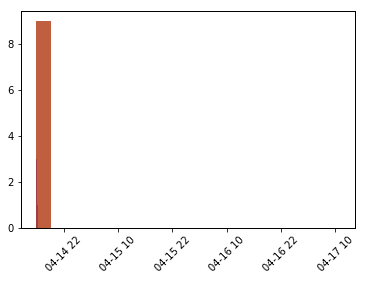



userId=8aac4d39-50bc-41b6-9715-79c2b0dd918c
more than one important day!

events:
first:2018-04-14 14:56:00+00:00
last:2018-04-17 11:06:00+00:00

posttests:
496   2018-04-14 16:17:00+00:00
497   2018-04-14 16:17:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]


In [ ]:
for userId in samplePlaytest[QUserId].unique():
    plotEventsPerMinute(userId, rmdfConcat, samplePlaytest)

------------

In [ ]:
gformProfiles = getUniqueProfiles(gform)
wholeProfiles = getUniqueProfiles(sampleWhole)
linuxProfiles = getUniqueProfiles(sampleLinux)
len(gformProfiles), len(wholeProfiles), len(linuxProfiles)

In [ ]:
playtestProfiles = getUniqueProfiles(samplePlaytest)
playtestProfilesPhase1 = getUniqueProfiles(samplePlaytestPhase1)
playtestProfilesPhase2 = getUniqueProfiles(samplePlaytestPhase2)

assert(len(playtestProfiles) == len(playtestProfilesPhase1) + len(playtestProfilesPhase2))

len(playtestProfiles),\
len(playtestProfilesPhase1),\
len(playtestProfilesPhase2)

In [ ]:
shouldBeEmpty = samplePlaytest[((samplePlaytest[QTimestamp] > playtest2018Phase1EndDate)&(samplePlaytest[QTimestamp] < playtest2018Phase2StartDate))]
assert(len(shouldBeEmpty) == 0)

In [ ]:
playtestProfiles = playtestProfiles.dropna(how='any')
playtestProfilesPhase1 = playtestProfilesPhase1.dropna(how='any')
playtestProfilesPhase2 = playtestProfilesPhase2.dropna(how='any')

assert(len(playtestProfiles) == len(playtestProfilesPhase1) + len(playtestProfilesPhase2))

len(playtestProfiles),\
len(playtestProfilesPhase1),\
len(playtestProfilesPhase2)

In [ ]:
# intersections based on userId and/or questions
s1 = pd.merge(playtestProfilesPhase1, playtestProfilesPhase2, how='inner', on=[QUserId])
s2 = pd.merge(playtestProfilesPhase1, playtestProfilesPhase2, how='inner', on=[QUserId, QAge, QGender])
len(s1), len(s2)

In [ ]:
playtestProfiles[QUserId].nunique(), playtestProfilesPhase1[QUserId].nunique(), playtestProfilesPhase2[QUserId].nunique(), 

#### RedMetrics dataframes

In [ ]:

rmdfPlaytest = rmdfLinuxPlatform[((rmdfLinuxPlatform['userTime'] > playtest2018Phase1StartDate)&(rmdfLinuxPlatform['userTime'] < playtest2018Phase2EndDate))]
rmdfPlaytest = rmdfPlaytest[rmdfPlaytest[QUserId].isin(samplePlaytest[QUserId].unique())]

rmdfPlaytestPhase1 = rmdfPlaytest[rmdfPlaytest[QUserId].isin(samplePlaytestPhase1[QUserId])]
rmdfPlaytestPhase1 = rmdfPlaytestPhase1[rmdfPlaytestPhase1['userTime'] < playtest2018Phase1EndDate]
rmdfPlaytestPhase2 = rmdfPlaytest[rmdfPlaytest[QUserId].isin(samplePlaytestPhase2[QUserId])]
rmdfPlaytestPhase2 = rmdfPlaytestPhase2[rmdfPlaytestPhase2['userTime'] > playtest2018Phase2StartDate]

rmdfPlaytestPretestPosttest = rmdfPlaytest[rmdfPlaytest[QUserId].isin(samplePlaytestPretestPosttest[QUserId])]
rmdfPlaytestPretestPosttestPhase1 = rmdfPlaytestPhase1[rmdfPlaytestPhase1[QUserId].isin(samplePlaytestPretestPosttestPhase1[QUserId])]
rmdfPlaytestPretestPosttestPhase2 = rmdfPlaytestPhase2[rmdfPlaytestPhase2[QUserId].isin(samplePlaytestPretestPosttestPhase2[QUserId])]

In [ ]:
assert(rmdfPlaytest[QUserId].nunique()       == samplePlaytest[QUserId].nunique())
assert(rmdfPlaytestPhase1[QUserId].nunique() == samplePlaytestPhase1[QUserId].nunique())
assert(rmdfPlaytestPhase2[QUserId].nunique() == samplePlaytestPhase2[QUserId].nunique())

### players

In [ ]:
thresholdGameEventsCount = 10
thresholdTimedelta = pd.Timedelta('0 days 00:05:00.000000')

playedEnoughTime = []
playedEnoughEvents = []

for userId in samplePlaytest[QUserId].unique():
    rows = rmdfPlaytest[rmdfPlaytest[QUserId] == userId]
    if len(rows) > thresholdGameEventsCount:
        playedEnoughEvents.append(userId)
    delta = rows['userTime'].max() - rows['userTime'].min()
    if delta > thresholdTimedelta:
        playedEnoughTime.append(userId)
        
len(samplePlaytest[QUserId].unique()), len(playedEnoughTime), len(playedEnoughEvents)

In [ ]:
setCount(rmdfPlaytestPhase1, phase1Label, playersCountLabel)
setCount(rmdfPlaytestPhase2, phase2Label, playersCountLabel)
setCount(rmdfPlaytest, totalLabel, playersCountLabel)
    
#assert(playtestStatistics.loc[totalLabel, playersCountLabel] == \
#    playtestStatistics.loc[phase1Label, playersCountLabel]\
#    + playtestStatistics.loc[phase2Label, playersCountLabel])

playtestStatistics

### all playtest responders

In [ ]:
plotGender(samplePlaytest,'Sexe des participants, phase 1')

In [ ]:
plotGender(samplePlaytestPhase2,'Sexe des participants, phase 2')

In [ ]:
plotAge(samplePlaytest, "Âge des participants, total")
plotAge(samplePlaytestPhase1, "Âge des participants, phase 1")
plotAge(samplePlaytestPhase2, "Âge des participants, phase 2")

In [ ]:
plotAgeGroups(samplePlaytest, pivotalAgesList = [1,15,25,35,45], title = 'Âge des participants, total', showCount = True)
plotAgeGroups(samplePlaytestPhase1, pivotalAgesList = [1,15,25,35,45], title = 'Âge des participants, phase 1', showCount = True)
plotAgeGroups(samplePlaytestPhase2, pivotalAgesList = [1,15,25,35,45], title = 'Âge des participants, phase 2', showCount = True)

In [ ]:
setGenderedCount(rmdfPlaytestPretestPosttestPhase1, samplePlaytestPhase1, phase1Label, respondersCountLabel)
setGenderedCount(rmdfPlaytestPretestPosttestPhase2, samplePlaytestPhase2,  phase2Label, respondersCountLabel)
setGenderedCount(rmdfPlaytestPretestPosttest, samplePlaytest,  totalLabel, respondersCountLabel, plotPie = True, title = 'Gender of participants (all)')

assert(playtestStatistics.loc[totalLabel, respondersCountLabel] ==\
       playtestStatistics.loc[phase1Label, respondersCountLabel]\
      + playtestStatistics.loc[phase2Label, respondersCountLabel])

playtestStatistics

In [ ]:
# answers per userId
# => gform.indexes per userId
indicesPerUserId = gform[QUserId].value_counts()
#indicesPerUserId

### twice responders

In [ ]:
twiceResponders = getPerfectPretestPostestPairs(gform)
playtestTwiceResponders = twiceResponders[twiceResponders[QUserId].isin(samplePlaytest[QUserId])]

uniquePlaytestPhase1TwiceResponders = samplePlaytestPhase1[samplePlaytestPhase1[QUserId].isin(playtestTwiceResponders[QUserId])]
uniquePlaytestPhase2TwiceResponders = samplePlaytestPhase2[samplePlaytestPhase2[QUserId].isin(playtestTwiceResponders[QUserId])]
uniquePlaytestTwiceResponders = samplePlaytest[samplePlaytest[QUserId].isin(playtestTwiceResponders[QUserId])]

setGenderedCount(uniquePlaytestPhase1TwiceResponders, playtestTwiceResponders, phase1Label, respondersTwiceCountLabel)
setGenderedCount(uniquePlaytestPhase2TwiceResponders, playtestTwiceResponders,  phase2Label, respondersTwiceCountLabel)
setGenderedCount(uniquePlaytestTwiceResponders, playtestTwiceResponders,  totalLabel, respondersTwiceCountLabel, plotPie = True, title = 'Gender of participants (pretest-posttest)')

assert(playtestStatistics.loc[totalLabel, respondersTwiceCountLabel] ==\
       playtestStatistics.loc[phase1Label, respondersTwiceCountLabel]\
      + playtestStatistics.loc[phase2Label, respondersTwiceCountLabel])

playtestStatistics

In [ ]:
plotAge(playtestTwiceResponders, 'Age repartition of pretest-posttest participants')

In [ ]:
gform[gform[QTemporality] == answerTemporalities[0]][QEnjoyed].apply(str).value_counts()

In [ ]:
gform[QAge].apply(str).value_counts()['nan']

In [ ]:
gform[gform[QAge].apply(str) == 'nan'][QTemporality].unique()